# Spatial Active Noise Control Based on Kernel Interpolation of Sound Field
An active noise control (ANC) method to reduce noise over a region in space based on kernel interpolation of sound field

- Paper: https://doi.org/10.1109/TASLP.2021.3107983
- Codes: https://github.com/sh01k/KernelInterpSpatialANC

by [Shoichi Koyama](https://www.sh01.org/), Jesper Brunnström, Hayato Ito, [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import numpy as np
import scipy.spatial.distance as distfuncs
import scipy.special as special

import sf_func as sf

plt.rcParams["font.size"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
###### Geometry ######

# Simulating region
limSim = (-1.2, 1.2) # range of simulating region (m)
numSim = (120, 120) # number of simulating points
posSim = sf.uniformFilledRectangle(numSim, limSim)

# Target region
dimsEval = (1.0, 1.0) # size of target region
idxEval = (posSim[:,0] > -dimsEval[0]/2) & (posSim[:,0] < dimsEval[0]/2) & (posSim[:,1] > -dimsEval[1]/2) & (posSim[:,1] < dimsEval[1]/2)
posEval = posSim[idxEval]

# Error microphones
numErr = 24 
offsetErr = 0.03 
posErr_int = sf.equidistantRectangle(int(numErr/2), dimsEval)
posErr_out = sf.equidistantRectangle(int(numErr/2), (dimsEval[0]+offsetErr, dimsEval[1]+offsetErr))
posErr = np.concatenate([posErr_int, posErr_out], 0)
posErr = sf.equidistantRectangle(numErr, dimsEval)
for i in np.arange(numErr)[1::2]:
    if np.isclose(posErr[i, 0], dimsEval[0] / 2):
        posErr[i, 0] += offsetErr
    elif np.isclose(posErr[i, 0], -dimsEval[0] / 2):
        posErr[i, 0] -= offsetErr
    elif np.isclose(posErr[i, 1], dimsEval[1] / 2):
        posErr[i, 1] += offsetErr
    elif np.isclose(posErr[i, 1], -dimsEval[1] / 2):
        posErr[i, 1] -= offsetErr
    else:
        raise ValueError

# Secondary loudspeakers
numSpk =  12 
dimsSpk = (2.0, 2.0)
radSpk = 1.0
posSpk = sf.equidistantRectangle(numSpk, dimsSpk)


In [12]:
###### Parameters ######

# Sound speed (m/s)
c = 343

# Frequency (Hz)
numFreq = 91
freq = np.linspace(100, 1000, numFreq)

# Wave number (rad/m)
k = 2*np.pi*freq / c

# Transfer functions from secondary loudspeakers to simulating region
Gsim = sf.PointSource(k, posSpk, posSim)

# Secondary path
G = sf.PointSource(k, posSpk, posErr)


In [13]:
###### Kernel interpolation matrix ######
kerReg = 1e-4 #1e-2 #
kerBeta = 2.0
#kerAng = np.arctan2(posSrc[0,1],posSrc[0,0])

mcNumPoints = 1000
mcPointGen, mcVolume = sf.block_rect([dimsEval[0], dimsEval[1]], np.random.RandomState(2))
#mcPointGen, mcVolume = block_circ(radEval, np.random.RandomState(2))

func = sf.integrableAFunc(k, posErr)
#func = integrableAwFunc(k, posErr)

integralVal = sf.integrate(func, mcPointGen, mcNumPoints, mcVolume)

distMat = distfuncs.cdist(posErr, posErr)[None, :, :]
K = special.j0(k[:,None,None] * distMat)
K_inv = np.linalg.inv(K + kerReg * np.eye(numErr))
A = np.transpose(K_inv.conj(), (0,2,1)) @ integralVal @ K_inv

Starting monte carlo integration 
 Samples per block:  50 
Total samples:  1000
Block  0
Block  1
Block  2
Block  3
Block  4
Block  5
Block  6
Block  7
Block  8
Block  9
Block  10
Block  11
Block  12
Block  13
Block  14
Block  15
Block  16
Block  17
Block  18
Block  19
Finished!!


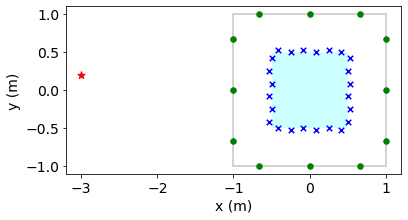

In [14]:
###### Single source case ######

# Primary source
numSrc = 1
posSrc = np.array([[-3, 0.2]], dtype=np.float64)

# Reference microphones
numRef = numSrc
posRef = posSrc

# Draw 
fig, ax = plt.subplots()
ax.add_patch(Rectangle([-dimsSpk[0]/2, -dimsSpk[1]/2], dimsSpk[0], dimsSpk[1], edgecolor='lightgrey', linestyle="solid", linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], facecolor='aqua', alpha=0.2, fill=True, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=3)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=4)
plt.scatter(posSrc[:,0], posSrc[:,1], s=60, c='r', marker="*")
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [15]:
# Source signal
s = 10.0 * np.ones((freq.shape[0], numSrc))

# Primary noise in simulating region
dist_noise = np.sum(s[:,None,:] * sf.PointSource(k, posSrc, posSim), axis=2)[:,:,None]

# Reference signal
x = s

# Primary noise at error mics
d = np.sum(s[:,None,:] * sf.PointSource(k, posSrc, posErr), axis=2)[:,:,None]

# Correlation matrices
eps = 1e-4
Rxx_inv = np.linalg.inv(x[:,:,None] * x[:,None,:].conj() + eps * np.identity(numRef))
Rdx = d @ np.transpose(x[:,:,None].conj(), (0,2,1))

# Control filter - Proposed
GA_inv = np.linalg.inv(np.transpose(G.conj(),(0,2,1)) @ A @ G)
W_KI = - GA_inv @ np.transpose(G.conj(),(0,2,1)) @ A @ Rdx @ Rxx_inv

# Control filter - MPC
G_inv = np.linalg.inv(np.transpose(G.conj(),(0,2,1)) @ G)
W_MPC = - G_inv @ np.transpose(G.conj(),(0,2,1)) @ Rdx @ Rxx_inv

# Driving signal
y_KI = W_KI @ x[:,:,None]
y_MPC = W_MPC @ x[:,:,None]

# Distribution
distKI = dist_noise + Gsim @ y_KI
distMPC = dist_noise + Gsim @ y_MPC

plt_freq_idx = 60 #50
print("Frequency of plots: ",freq[plt_freq_idx])
pw_norm = np.sum(np.abs(dist_noise[plt_freq_idx,idxEval])**2) / dist_noise[plt_freq_idx,idxEval].size

pw_distKI = 10*np.log10( np.abs(distKI[plt_freq_idx,:])**2 / pw_norm)
pw_distMPC = 10*np.log10( np.abs(distMPC[plt_freq_idx,:])**2 / pw_norm)

# Regional reduction
predKI = 10*np.log10( np.sum(np.abs(distKI[:,idxEval])**2, axis=1) / np.sum(np.abs(dist_noise[:,idxEval])**2, axis=1) )
predMPC = 10*np.log10( np.sum(np.abs(distMPC[:,idxEval])**2, axis=1) / np.sum(np.abs(dist_noise[:,idxEval])**2, axis=1) )

print('Pred - MPC:', predMPC[plt_freq_idx])
print('Pred - KI:', predKI[plt_freq_idx])


Frequency of plots:  700.0
Pred - MPC: [0.55013643]
Pred - KI: [-9.97388062]


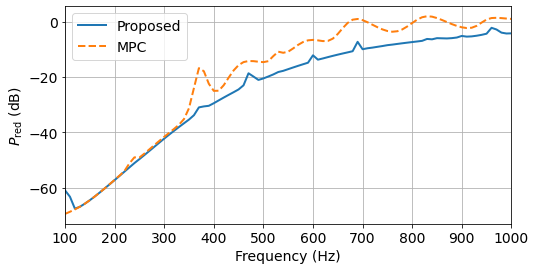

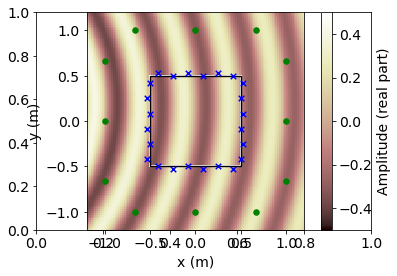

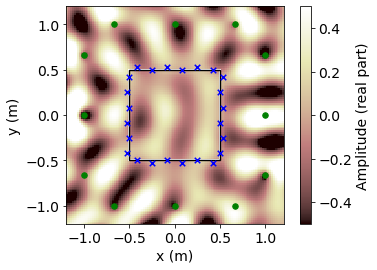

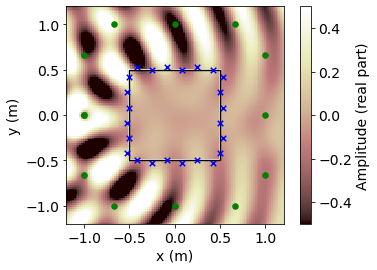

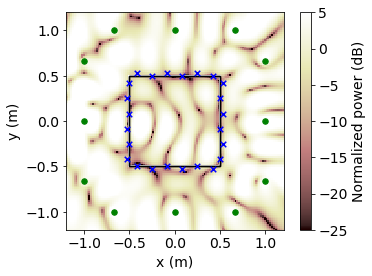

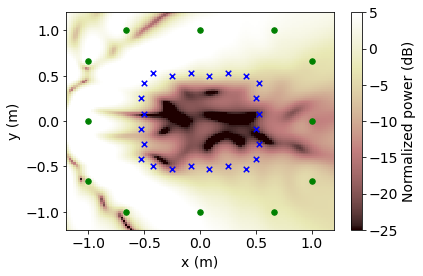

In [16]:
# Draw
fig,ax = plt.subplots(figsize=(8.0, 4.0))
ax.plot(freq, predKI, '-', linewidth=2, label="Proposed")
ax.plot(freq, predMPC, '--', linewidth=2, label="MPC")
ax.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('$P_{\mathrm{red}}$ (dB)')
plt.xlim([100,1000])
plt.grid()
#fig.savefig('pred.pdf')

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(posSim[:,0].reshape(numSim), posSim[:,1].reshape(numSim), dist_noise[plt_freq_idx,:].real.reshape(numSim), cmap='pink', shading='auto', vmin=-0.5, vmax=0.5)
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='w', linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='k', linewidth=1.4, fill=False, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=4)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=3)
ax.set_aspect('equal')
plt.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
cbar=plt.colorbar(color)
cbar.set_label('Amplitude (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig('dist_amp_primary.pdf')

fig, ax = plt.subplots()
color = plt.pcolor(posSim[:,0].reshape(numSim), posSim[:,1].reshape(numSim), distMPC[plt_freq_idx,:].real.reshape(numSim), cmap='pink', shading='auto', vmin=-0.5, vmax=0.5)
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='w', linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='k', linewidth=1.4, fill=False, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=4)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=3)
ax.set_aspect('equal')
plt.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
cbar=plt.colorbar(color)
cbar.set_label('Amplitude (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig('dist_amp_MPC.pdf')

fig, ax = plt.subplots()
color = plt.pcolor(posSim[:,0].reshape(numSim), posSim[:,1].reshape(numSim), distKI[plt_freq_idx,:].real.reshape(numSim), cmap='pink', shading='auto', vmin=-0.5, vmax=0.5)
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='w', linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='k', linewidth=1.4, fill=False, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=4)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=3)
ax.set_aspect('equal')
plt.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
cbar=plt.colorbar(color)
cbar.set_label('Amplitude (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig('dist_amp_KI.pdf')

fig, ax = plt.subplots()
color = plt.pcolor(posSim[:,0].reshape(numSim), posSim[:,1].reshape(numSim), pw_distMPC.reshape(numSim), cmap='pink', shading='auto', vmin=-25, vmax=5)
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='w', linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='k', linewidth=1.4, fill=False, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=4)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=3)
ax.set_aspect('equal')
plt.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
cbar=plt.colorbar(color)
cbar.set_label('Normalized power (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig('dist_pw_MPC.pdf')

fig = plt.subplots()
color = plt.pcolor(posSim[:,0].reshape(numSim), posSim[:,1].reshape(numSim), pw_distKI.reshape(numSim), cmap='pink', shading='auto', vmin=-25, vmax=5)
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='w', linewidth=2, fill=False, zorder=1))
ax.add_patch(Rectangle([-dimsEval[0]/2, -dimsEval[1]/2], dimsEval[0], dimsEval[1], edgecolor='k', linewidth=1.4, fill=False, zorder=2))
plt.scatter(posSpk[:,0], posSpk[:,1], s=30, c='g', marker="o", zorder=4)
plt.scatter(posErr[:,0], posErr[:,1], s=30, c='b', marker="x", zorder=3)
ax.set_aspect('equal')
plt.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
cbar=plt.colorbar(color)
cbar.set_label('Normalized power (dB)', fontsize = 14)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig('dist_pw_KI.pdf')

plt.show()
